In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import random
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact


In [8]:
anime = pd.read_csv("/content/anime.csv")
ratings = pd.read_csv("/content/rating_complete.csv")

In [9]:
anime = anime.drop(columns=['Japanese name', 'Studios','Rating','Producers','Premiered','Type', 'Aired', 'Licensors','Members','Favorites','Source','Duration','Watching','Completed','On-Hold','Dropped','Plan to Watch','Score-10','Score-9','Score-8','Score-7','Score-6','Score-5','Score-4','Score-3','Score-2','Score-1'])

In [10]:
#removes entries with no scores
anime = anime[ anime['Score'].str.contains('Unknown') == False]
anime = anime[ anime['Ranked'].str.contains('Unknown') == False]
#Removes entries that contain adult content
anime = anime[ anime['Genres'].str.contains("Hentai") == False]
anime.size

88504

In [11]:
#converts values in these columns to numerical data types
anime['Score'] = anime['Score'].apply(pd.to_numeric)
anime['Ranked'] = anime['Ranked'].apply(pd.to_numeric)
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11063 entries, 0 to 17552
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MAL_ID        11063 non-null  int64  
 1   Name          11063 non-null  object 
 2   Score         11063 non-null  float64
 3   Genres        11063 non-null  object 
 4   English name  11063 non-null  object 
 5   Episodes      11063 non-null  object 
 6   Ranked        11063 non-null  float64
 7   Popularity    11063 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 777.9+ KB


In [12]:
# replaces any unknown values with the value from the Name column
for row in anime.index:
    if anime.loc[row, 'English name'] == 'Unknown':
        anime.loc[row, 'English name'] = anime.loc[row, 'Name']

In [13]:
#Removes shows that are less popular leaving only the top 60% of shows
pop_thresh = anime['Ranked'].max() * 0.60
print(pop_thresh)
print(len(anime))
anime_thresh = anime[anime['Ranked'] < pop_thresh]
print(len(anime_thresh))

6644.4
11063
6646


In [14]:
anime = anime_thresh
print(len(anime))

6646


In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507401 entries, 0 to 7507400
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 171.8 MB


In [16]:
ratings = ratings[ratings['user_id']  < ratings['user_id'].max() * .80]

In [17]:
# User should rate atleast 400 animies
n_ratings = ratings['user_id'].value_counts()
rate_thresh = ratings[ratings['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
rate_thresh = rate_thresh[rate_thresh['user_id'] < rate_thresh['user_id'].max() * 0.5]
len(rate_thresh)

1276286

In [18]:
ratings = rate_thresh

In [19]:
# renames the anime_id column to MAL_id to match the other data set
ratings = ratings.rename(index = str, columns={"anime_id":"MAL_ID"})
anime_merged = anime.merge(ratings, on = 'MAL_ID')
print(len(anime_merged))

1133344


In [20]:
anime_ratings = anime_merged
anime_data = anime

In [21]:
# Takes the top 1000 most popular shows and imports user scores into a pivot table
top_rating = anime_ratings.sort_values(by='Popularity')
top_rating = top_rating[top_rating['Popularity'] < 1001]
anime_pt = top_rating.pivot_table(index = 'English name', columns = 'user_id',values = 'rating').fillna(0)
anime_pt.head()

user_id,17,19,42,53,73,111,112,121,145,146,...,18327,18349,18355,18359,18360,18375,18387,18394,18407,18414
English name,,,,,,,,,,,,,,,,,,,,,
.hack//Sign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,6.0,0.0,0.0,0.0,5.0,6.0,5.0,6.0
07-Ghost,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0,7.0,0.0
5 Centimeters Per Second,6.0,8.0,6.0,6.0,8.0,7.0,0.0,10.0,9.0,8.0,...,9.0,6.0,9.0,0.0,8.0,0.0,8.0,9.0,5.0,7.0
91 Days,9.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,8.0,...,0.0,8.0,0.0,0.0,0.0,7.0,9.0,6.0,5.0,6.0
A Certain Magical Index,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,8.0,6.0,6.0,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

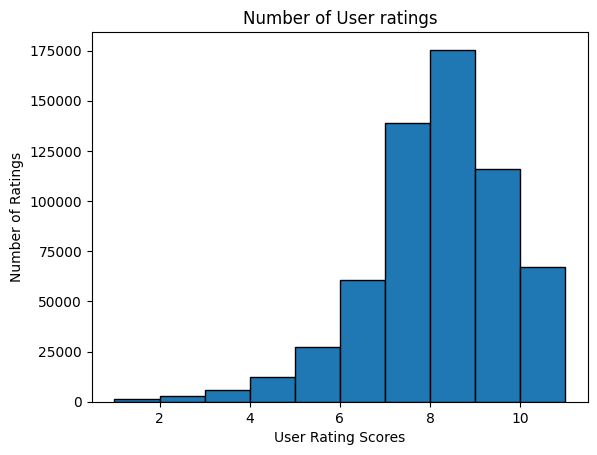

In [22]:
# create a histogram of user scores
ratings = top_rating['rating']
plt.hist(ratings, bins=10, range = (1,11), edgecolor='black')
plt.title('Number of User ratings')
plt.xlabel('User Rating Scores')
plt.ylabel('Number of Ratings')
plt.show

In [23]:
# Converts the pivot table to a sparse matrix
anime_matrix = csr_matrix(anime_pt.values)

In [24]:
# Fit nearest neighbors model
anime_nn = NearestNeighbors(metric='cosine', algorithm='brute')
anime_nn.fit(anime_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [26]:
# create an empty list to store lists of indices for each user
top_anime_indices = []

# loop over each user in the test data
for i in range(anime_pt.shape[1]):
    user_ratings = anime_pt.iloc[:, i].values >= 9
    # Create an inner list including indices for top rated shows
    top_anime_inner = []
    for j, rating in enumerate(user_ratings):
        if rating:
            top_anime_inner.append(j)
    # if the user has at least 20 top rated shows then their list is added to the outer list
    # This helps with testing since we will be comparing 10 recommended shows to the user's actual list
    if len(top_anime_inner) > 20:
        top_anime_indices.append(top_anime_inner)

In [27]:
accuracy = []
# loop over every user in our 2d array
for user in range(len(top_anime_indices)):
    anime_index = random.choice(top_anime_indices[user])
    #print(anime_index)
    distances, indices = anime_nn.kneighbors(anime_pt.iloc[anime_index,:].values.reshape(1, -1), n_neighbors = 11)
    recommended_anime_indices = indices[0]

    num_correct = len(set(recommended_anime_indices).intersection(set(top_anime_indices[user])))
    accuracy.append(num_correct / 10)

# calculate the accuracy as the proportion of correct predictions
accuracy = sum(accuracy) / len(accuracy)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 52.58%


In [28]:
def get_recommendations(user_input):
    # take user input and run it through the model in order to generate recommendations
    #user_input = input('Please enter the name of an anime: ')
    try:
        query_index = anime_pt[anime_pt.index == user_input].iloc[0]
        #print(query_index)
        distances, indices = anime_nn.kneighbors(query_index.values.reshape(1, -1), n_neighbors = 11)
        #print(indices)
        # Output the recommended shows in a user readable format
        for i in range(0, len(distances.flatten())):
            if i == 0:
                print('Recommendations for {0}:\n'.format(user_input))
            else:
                print('{0}: {1}'.format(i, anime_pt.index[indices.flatten()[i]]))
    except Exception as e:
        print('Anime name not found.')

In [30]:
# create a list of titles for the combo box
anime_titles = anime_pt.index.tolist()
# create a combo box widget
anime_select = widgets.Combobox(
    placeholder='Anime Name',
    options=anime_titles,
    description='Please select an anime: ',
    ensure_option=True,
    disabled=False
)
# provide functionality to the combo box

interact(get_recommendations, user_input=anime_select)

interactive(children=(Combobox(value='', description='Please select an anime: ', ensure_option=True, options=(…

<function __main__.get_recommendations(user_input)>